In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import os
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime
from datetime import date, timedelta
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

data_path = 'D:/universidad/universidad 4/TFG/recursos para el desarrollo/datos procesados/OD'

In [2]:
delta = e_date - i_date

target_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    target_days.append(day)

In [3]:
def read_OD_fn(source_type):
    ods = {}
    for date in tqdm_notebook(target_days):
        od_date= pd.read_csv(os.path.join(data_path, 'date_{}_OD_{}.csv'.format(source_type,date.strftime('%Y-%m-%d'))), 
                            index_col=0)
        ods[date] = od_date
    return ods

In [4]:
ine_ods = read_OD_fn('INE')

  0%|          | 0/81 [00:00<?, ?it/s]

# Serializar los datos

In [5]:
lista = []

for date in tqdm_notebook(target_days):
    lista.append(ine_ods[date].loc['total','total'])
    
del ine_ods

  0%|          | 0/81 [00:00<?, ?it/s]

In [6]:
df = pd.DataFrame (lista, columns = ['Viajes'], index= target_days)

In [7]:
df.head()

,Viajes
2020-04-01,2213123
2020-04-02,2254121
2020-04-03,2520095
2020-04-04,1934554
2020-04-05,1593385


# Visualización de datos

In [8]:
print(df.index.min())
print(df.index.max())

2020-04-01 00:00:00
2020-06-20 00:00:00


In [9]:
print(len(df['2020']))

81


In [10]:
df.describe()

,Viajes
count,8.100000e+01
mean,3.438222e+06
std,1.174931e+06
min,1.535886e+06
25%,2.488436e+06
50%,3.396402e+06
75%,4.445190e+06
max,5.519725e+06


In [11]:
meses = df.resample('M').mean()
meses

,Viajes
2020-04-30,2.356878e+06
2020-05-31,3.590722e+06
2020-06-30,4.823862e+06


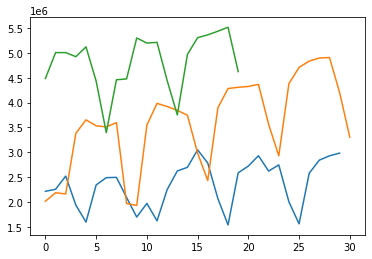

In [12]:
abril = df['2020-04-01':'2020-04-30']
plt.plot(abril.values)
mayo = df['2020-05-01':'2020-05-31']
plt.plot(mayo.values)
junio = df['2020-06-01':'2020-06-20']
plt.plot(junio.values)

# Preprocesado de datos

In [13]:
# cantidad de dias previos que se usaran para predecir el siguiente dia 
look_back=7

# convertir series en conocimiento supervisado
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # secuencia de entrada (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # secuencia del pronostico (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # unimos todo
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # eliminamos todos los valores nulos
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# cargamos el dataframe en la variable values
values = df.values

# convertimos los enteros en floats
values = values.astype('float32')

# normalizamos los datos a escala de entre -1 y 1
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

# usamos la funcion definida previamente
reframed = series_to_supervised(scaled, look_back, 1)

# imprimimos los nuevos datos
reframed.tail()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
76,0.477061,0.891413,0.839957,0.847171,0.460553,0.113062,0.725623,0.894152
77,0.891413,0.839957,0.847171,0.460553,0.113062,0.725623,0.894152,0.923149
78,0.839957,0.847171,0.460553,0.113062,0.725623,0.894152,0.923149,0.959687
79,0.847171,0.460553,0.113062,0.725623,0.894152,0.923149,0.959687,1.000000
80,0.460553,0.113062,0.725623,0.894152,0.923149,0.959687,1.000000,0.551599


# Dividimos los datos en sets de entrenamiento y validacion

In [14]:
# dividimos nuestro valores entre sets de entrenamiento y de test
values = reframed.values
n_train_days = 71 - (10+look_back)
train = values[:n_train_days, :]
test = values[n_train_days:, :]

# los volvemos a dividir en entradas y salidas
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]

# remodelamos la muestras para ser de las dimensiones [samples, timesteps, features]
trainX = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
testX = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))

print(trainX.shape, y_train.shape, testX.shape, y_val.shape)

(54, 1, 7) (54,) (20, 1, 7) (20,)


# Creamos la red neuronal

In [15]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(look_back, input_shape=(1,look_back),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(100, activation='tanh'))
    model.add(Dropout(0.30))
    model.add(Dense(100, activation='tanh'))
    model.add(Dropout(0.30))
    model.add(Dense(100, activation='tanh'))
    model.add(Dropout(0.30))
    model.add(Dense(100, activation='tanh'))
    model.add(Dropout(0.30))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [16]:
EPOCHS=200

model = crear_modeloFF()

history=model.fit(trainX,y_train,epochs=EPOCHS,validation_data=(testX,y_val),batch_size=look_back)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 7)              56        
_________________________________________________________________
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               800       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               1

Epoch 50/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1556 - mse: 0.0427 - val_loss: 0.1488 - val_mse: 0.0348
Epoch 51/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1682 - mse: 0.0448 - val_loss: 0.1537 - val_mse: 0.0378
Epoch 52/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1721 - mse: 0.0493 - val_loss: 0.1240 - val_mse: 0.0235
Epoch 53/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1781 - mse: 0.0656 - val_loss: 0.1208 - val_mse: 0.0221
Epoch 54/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1821 - mse: 0.0505 - val_loss: 0.1248 - val_mse: 0.0240
Epoch 55/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1930 - mse: 0.0538 - val_loss: 0.1329 - val_mse: 0.0254
Epoch 56/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1817 - mse: 0.0598 - val_loss: 0.1567 - val_mse: 0.0341
Epoch 57/200
8/8 [==============================] - 0s 6ms/step - loss: 0.1541 - mse: 0.04

Epoch 113/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1779 - mse: 0.0476 - val_loss: 0.1268 - val_mse: 0.0231
Epoch 114/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1731 - mse: 0.0496 - val_loss: 0.1331 - val_mse: 0.0257
Epoch 115/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1452 - mse: 0.0377 - val_loss: 0.1361 - val_mse: 0.0269
Epoch 116/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1698 - mse: 0.0477 - val_loss: 0.1321 - val_mse: 0.0237
Epoch 117/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1764 - mse: 0.0634 - val_loss: 0.1282 - val_mse: 0.0230
Epoch 118/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1669 - mse: 0.0460 - val_loss: 0.1222 - val_mse: 0.0219
Epoch 119/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1781 - mse: 0.0546 - val_loss: 0.1321 - val_mse: 0.0258
Epoch 120/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1493 - m

Epoch 175/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1643 - mse: 0.0420 - val_loss: 0.1292 - val_mse: 0.0232
Epoch 176/200
8/8 [==============================] - ETA: 0s - loss: 0.1873 - mse: 0.050 - 0s 7ms/step - loss: 0.1563 - mse: 0.0403 - val_loss: 0.1286 - val_mse: 0.0242
Epoch 177/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1343 - mse: 0.0312 - val_loss: 0.1465 - val_mse: 0.0289
Epoch 178/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1654 - mse: 0.0502 - val_loss: 0.1391 - val_mse: 0.0266
Epoch 179/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1711 - mse: 0.0450 - val_loss: 0.1366 - val_mse: 0.0279
Epoch 180/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1455 - mse: 0.0329 - val_loss: 0.1323 - val_mse: 0.0260
Epoch 181/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1543 - mse: 0.0413 - val_loss: 0.1274 - val_mse: 0.0233
Epoch 182/200
8/8 [==========================

# Visualizamos resultados

In [17]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


def compute_metrics_fn(y_valid_resc, y_hat_resc):
    mae_ = mean_absolute_error(y_valid_resc, y_hat_resc)
    mse_ = mean_squared_error(y_valid_resc, y_hat_resc)
    rmse_ = mean_squared_error(y_valid_resc, y_hat_resc, squared = False)
    cvrmse_ = rmse_/np.mean(y_valid_resc)*100
    mape_ = mape(y_valid_resc, y_hat_resc)
    
    return mae_, mse_, rmse_, cvrmse_, mape_

In [18]:
# hacemos las predicciones
trainPredict = model.predict(x_train)
testPredict = model.predict(x_val)

# invertimos las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY = y_train.reshape(y_train.shape[0], 1)
trainY_scalerInverse = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = y_val.reshape(y_val.shape[0], 1)
testY_scalerInverse = scaler.inverse_transform(testY)

In [19]:
# calculamos las metricas de error
trainScore_MAE, trainScore_MSE, trainScore_RMSE, trainScore_CVRMSE, trainScore_MAPE  =  compute_metrics_fn(trainY_scalerInverse, trainPredict)
print('Resultado del entrenamiento: %.2f MAE' % (trainScore_MAE))
print('Resultado del entrenamiento: %.2f MSE' % (trainScore_MSE))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore_RMSE))
print('Resultado del entrenamiento: %.2f CVRMSE' % (trainScore_CVRMSE))
print('Resultado del entrenamiento: %.2f MAPE \n' % (trainScore_MAPE))

testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(testY_scalerInverse, testPredict)
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del entrenamiento: 261109.48 MAE
Resultado del entrenamiento: 132379295744.00 MSE
Resultado del entrenamiento: 363839.66 RMSE
Resultado del entrenamiento: 11.79 CVRMSE
Resultado del entrenamiento: 10.19 MAPE 

Resultado del test: 257936.55 MAE
Resultado del test: 93368950784.00 MSE
Resultado del test: 305563.34 RMSE
Resultado del test: 6.33 CVRMSE
Resultado del test: 5.61 MAPE


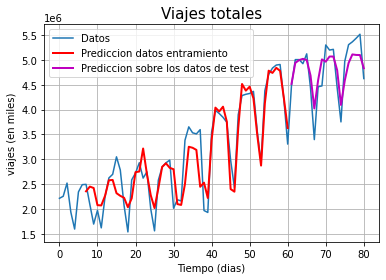

In [20]:
dataset = df.values
dataset = dataset.astype('float32')
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# predicciones del test de cambio para plotear
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back):len(dataset), :] = testPredict
# plot baseline and predictions
plt.plot(df.values)
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.title("Viajes totales", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

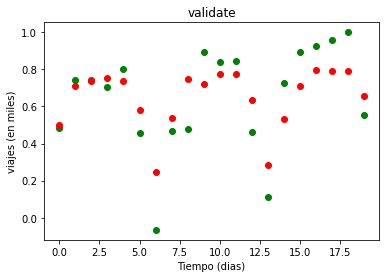

In [21]:
results=model.predict(x_val)

plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

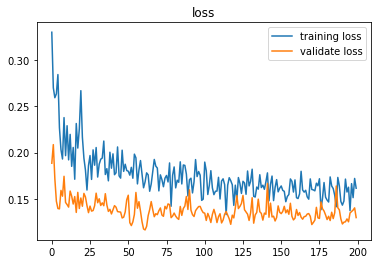

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.legend( ('training loss', 'validate loss'), loc = 'upper right')
plt.show()

# Prediccion a futuro

In [23]:
# usaremos los 14 ultimos dias del confinamiento en junio para predecir como habrian sido los dias del 21 al 27 en caso de que
# el confinamiento se hubiese alargado por una semana mas

ultimosDias = df['2020-6-7':'2020-6-20']
ultimosDias

,Viajes
2020-06-07,3396402
2020-06-08,4461143
2020-06-09,4478072
2020-06-10,5303428
2020-06-11,5200931
2020-06-12,5215302
2020-06-13,4445190
2020-06-14,3753016
2020-06-15,4973188
2020-06-16,5308885


# Preparamos los datos para el test

In [24]:
# cargamos el dataframe en la variable values
values = ultimosDias.values

# convertimos los enteros en floats
values = values.astype('float32')

# normalizamos los datos a escala de entre -1 y 1
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

# usamos la funcion definida previamente
reframed = series_to_supervised(scaled, look_back, 1)

# eliminamos la ultima columna pues es parte de lo que queremos hayar
reframed.drop(reframed.columns[[7]], inplace=True, axis=1)
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,-1.000000,0.002901,0.018846,0.796266,0.699721,0.713258,-0.012126
8,0.002901,0.018846,0.796266,0.699721,0.713258,-0.012126,-0.664099
9,0.018846,0.796266,0.699721,0.713258,-0.012126,-0.664099,0.485206
10,0.796266,0.699721,0.713258,-0.012126,-0.664099,0.485206,0.801405
11,0.699721,0.713258,-0.012126,-0.664099,0.485206,0.801405,0.855810
12,0.713258,-0.012126,-0.664099,0.485206,0.801405,0.855810,0.924364
13,-0.012126,-0.664099,0.485206,0.801405,0.855810,0.924364,1.000000


In [25]:
values = reframed.values

#tomamos los valores para realizar el test
x_test = values[6:, :]

# reshape input to be 3D [samples, timesteps, features]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
x_test

(1, 1, 7)


array([[[-0.01212597, -0.6640985 ,  0.48520565,  0.80140543,
          0.8558097 ,  0.9243636 ,  1.        ]]], dtype=float32)

In [26]:
#definimos la funcion para realizar el desplazamiento que se hara en el array cada prediccion pues para hacer
#la siguiente prediccion eliminamos el dia mas antiguo, desplazamos un lugar el resto de dias y añadimos el ultimo dia que
#se ha predecido, esto es por que para predecir un dia se usan los 7 dias previos

def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

# Predicciones para la proxima semana

In [27]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

[[[-0.01212597 -0.6640985   0.48520565  0.80140543  0.8558097
    0.9243636   1.        ]]]
[[[-0.6640985   0.48520565  0.80140543  0.8558097   0.9243636
    1.          0.35432205]]]
[[[ 0.48520565  0.80140543  0.8558097   0.9243636   1.
    0.35432205 -0.2837686 ]]]
[[[ 0.80140543  0.8558097   0.9243636   1.          0.35432205
   -0.2837686   0.4852983 ]]]
[[[ 0.8558097   0.9243636   1.          0.35432205 -0.2837686
    0.4852983   0.76204985]]]
[[[ 0.9243636   1.          0.35432205 -0.2837686   0.4852983
    0.76204985  0.78097534]]]
[[[ 1.          0.35432205 -0.2837686   0.4852983   0.76204985
    0.78097534  0.80350524]]]


# Re-Convertimos los resultados

In [28]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([0.35432205], dtype=float32), array([-0.2837686], dtype=float32), array([0.4852983], dtype=float32), array([0.76204985], dtype=float32), array([0.78097534], dtype=float32), array([0.80350524], dtype=float32), array([0.8060538], dtype=float32)]


array([[4834233.77624418],
       [4156797.5277637 ],
       [4973286.22492803],
       [5267102.68082112],
       [5287195.14226506],
       [5311114.26914246],
       [5313819.99345461]])

# Visualizamos el pronostico

<AxesSubplot:>

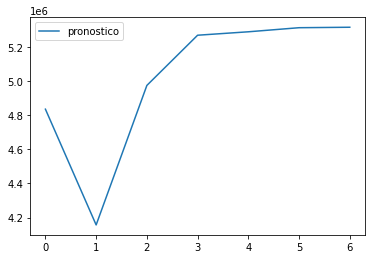

In [29]:
prediccion = pd.DataFrame(inverted)
prediccion.columns = ['pronostico']
prediccion.plot()

# Prediccion con datos actuales

In [30]:
# usaremos 14 dias que poseemos para predecir los 7 dias siguientes tras esto compararemos los resultados con los que
# poseemos para ver el grado de error

Dias = df['2020-5-11':'2020-5-24']
Dias

,Viajes
2020-05-11,3545526
2020-05-12,3985384
2020-05-13,3922169
2020-05-14,3845239
2020-05-15,3745419
2020-05-16,2983259
2020-05-17,2430478
2020-05-18,3896788
2020-05-19,4284420
2020-05-20,4309613


# Preparamos los datos para el test

In [31]:
# cargamos el dataframe en la variable values
values = Dias.values

# convertimos los enteros en floats
values = values.astype('float32')

# normalizamos los datos a escala de entre -1 y 1
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

# usamos la funcion definida previamente
reframed = series_to_supervised(scaled, look_back, 1)

# eliminamos la ultima columna pues es parte de lo que queremos hayar
reframed.drop(reframed.columns[[7]], inplace=True, axis=1)
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,0.150527,0.604381,0.539155,0.459777,0.356781,-0.429630,-1.000000
8,0.604381,0.539155,0.459777,0.356781,-0.429630,-1.000000,0.512966
9,0.539155,0.459777,0.356781,-0.429630,-1.000000,0.512966,0.912932
10,0.459777,0.356781,-0.429630,-1.000000,0.512966,0.912932,0.938927
11,0.356781,-0.429630,-1.000000,0.512966,0.912932,0.938927,0.955663
12,-0.429630,-1.000000,0.512966,0.912932,0.938927,0.955663,1.000000
13,-1.000000,0.512966,0.912932,0.938927,0.955663,1.000000,0.169306


In [32]:
values = reframed.values

#tomamos los valores para realizar el test
x_test = values[6:, :]

# reshape input to be 3D [samples, timesteps, features] - preguntar
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
x_test

(1, 1, 7)


array([[[-1.        ,  0.51296616,  0.9129319 ,  0.9389267 ,
          0.9556627 ,  1.        ,  0.16930556]]], dtype=float32)

In [33]:
#en la linea 24 definimos la funcion para realizar el desplazamiento que se hara en el array cada prediccion pues para hacer
#la siguiente prediccion eliminamos el dia mas antiguo, desplazamos un lugar el resto de dias y añadimos el ultimo dia que
#se ha predecido, esto es por que para predecir un dia se usan los 7 dias previos, y que usaremos a continuación

# Realizamos la prediccion 

In [34]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

[[[-1.          0.51296616  0.9129319   0.9389267   0.9556627
    1.          0.16930556]]]
[[[ 0.51296616  0.9129319   0.9389267   0.9556627   1.
    0.16930556 -0.5629339 ]]]
[[[ 0.9129319   0.9389267   0.9556627   1.          0.16930556
   -0.5629339   0.4460508 ]]]
[[[ 0.9389267   0.9556627   1.          0.16930556 -0.5629339
    0.4460508   0.7882569 ]]]
[[[ 0.9556627   1.          0.16930556 -0.5629339   0.4460508
    0.7882569   0.7972126 ]]]
[[[ 1.          0.16930556 -0.5629339   0.4460508   0.7882569
    0.7972126   0.8116993 ]]]
[[[ 0.16930556 -0.5629339   0.4460508   0.7882569   0.7972126
    0.8116993   0.7995247 ]]]


# Re-Convertimos los resultados

In [35]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)

#en nuestro problema no tienen sentido los decimales pues no se pueden hacer 0.5 viajes o 0.25 viajes
inverted = inverted.round()
inverted = inverted.astype(int)
inverted

[array([-0.5629339], dtype=float32), array([0.4460508], dtype=float32), array([0.7882569], dtype=float32), array([0.7972126], dtype=float32), array([0.8116993], dtype=float32), array([0.7995247], dtype=float32), array([0.429979], dtype=float32)]


array([[2854066],
       [3831936],
       [4163590],
       [4172269],
       [4186309],
       [4174510],
       [3816360]])

# Visualizamos el pronostico

<AxesSubplot:>

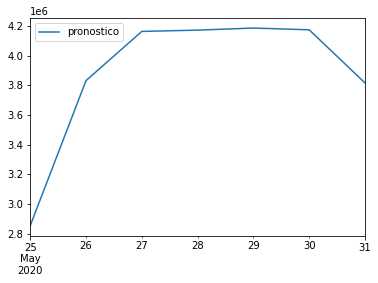

In [36]:
e_date = datetime.datetime.strptime('2020-05-31', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-05-25', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(inverted, index= index_days)
prediccion.columns = ['pronostico']
prediccion.plot()

In [37]:
datosReales = df['2020-5-25':'2020-5-31']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']
compara

,real,prediccion
2020-05-25,4382232,2854066
2020-05-26,4709433,3831936
2020-05-27,4837770,4163590
2020-05-28,4898946,4172269
2020-05-29,4909824,4186309
2020-05-30,4202334,4174510
2020-05-31,3305717,3816360


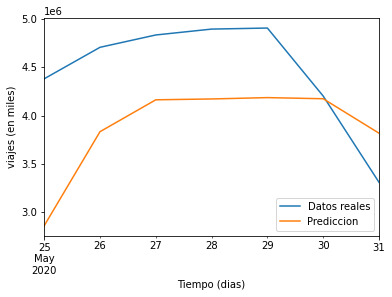

In [38]:
compara['real'].plot()
compara['prediccion'].plot()
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.legend( ('Datos reales', 'Prediccion'), loc = 'lower right')

In [39]:
# calculamos las metricas de error
testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion, datosReales)
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del test: 724071.71 MAE
Resultado del test: 696124978134.86 MSE
Resultado del test: 834341.04 RMSE
Resultado del test: 21.47 CVRMSE
Resultado del test: 20.20 MAPE


In [40]:
# calculamos las metricas de error para cada dia por separado
for i in range(7):
    testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion.values[i], datosReales.values[i])
    day = i + 1
    print('Resultado del test dia %d: %.2f MAE' % (day, testScore_MAE))
    print('Resultado del test dia %d: %.2f MSE' % (day, testScore_MSE))
    print('Resultado del test dia %d: %.2f RMSE' % (day, testScore_RMSE))
    print('Resultado del test dia %d: %.2f CVRMSE' % (day, testScore_CVRMSE))
    print('Resultado del test dia %d: %.2f MAPE \n' % (day, testScore_MAPE))

Resultado del test dia 1: 1528166.00 MAE
Resultado del test dia 1: 2335291323556.00 MSE
Resultado del test dia 1: 1528166.00 RMSE
Resultado del test dia 1: 53.54 CVRMSE
Resultado del test dia 1: 53.54 MAPE 

Resultado del test dia 2: 877497.00 MAE
Resultado del test dia 2: 770000985009.00 MSE
Resultado del test dia 2: 877497.00 RMSE
Resultado del test dia 2: 22.90 CVRMSE
Resultado del test dia 2: 22.90 MAPE 

Resultado del test dia 3: 674180.00 MAE
Resultado del test dia 3: 454518672400.00 MSE
Resultado del test dia 3: 674180.00 RMSE
Resultado del test dia 3: 16.19 CVRMSE
Resultado del test dia 3: 16.19 MAPE 

Resultado del test dia 4: 726677.00 MAE
Resultado del test dia 4: 528059462329.00 MSE
Resultado del test dia 4: 726677.00 RMSE
Resultado del test dia 4: 17.42 CVRMSE
Resultado del test dia 4: 17.42 MAPE 

Resultado del test dia 5: 723515.00 MAE
Resultado del test dia 5: 523473955225.00 MSE
Resultado del test dia 5: 723515.00 RMSE
Resultado del test dia 5: 17.28 CVRMSE
Resultado d